In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from numpy.random import uniform
from sklearn.datasets import make_blobs
import seaborn as sns
import random
from sklearn import metrics
from sklearn.metrics import pairwise_distances
def euclidean(point, data):
    return np.sqrt(np.sum((point - data)**2, axis=1))
class KMeans:
    def __init__(self, n_clusters=8, max_iter=50):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.centroids=[]
    def initializeCentroids(self):
        self.centroids = [random.choice(X_train)]
        for _ in range(self.n_clusters-1):
            dists = np.sum([euclidean(centroid, X_train) for centroid in self.centroids], axis=0)
            dists /= np.sum(dists)
            new_centroid_idx, = np.random.choice(range(len(X_train)), size=1, p=dists)
            self.centroids += [X_train[new_centroid_idx]]

    def inputCentroids(self, centroids):
        self.centroids=centroids

    def fit(self, X_train, verbose=0):

        iteration = 0
        prev_centroids = None
        while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
            # Sort each datapoint, assigning to nearest centroid
            sorted_points = [[] for _ in range(self.n_clusters)]
            for x in X_train:
                dists = euclidean(x, self.centroids)
                centroid_idx = np.argmin(dists)
                sorted_points[centroid_idx].append(x)
            # Push current centroids to previous, reassign centroids as mean of the points belonging to them
            prev_centroids = self.centroids
            self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():  # Catch any np.nans, resulting from a centroid having no points
                    self.centroids[i] = prev_centroids[i]
            iteration += 1
            if verbose==1:
                _,_,score=self.evaluate(X_train)
                print("Iteration: ", iteration, " Score: ", score)
    def evaluate(self, X):
        centroids = []
        centroid_idxs = []
        for x in X:
            dists = euclidean(x, self.centroids)
            centroid_idx = np.argmin(dists)
            centroids.append(self.centroids[centroid_idx])
            centroid_idxs.append(centroid_idx)
        score=[metrics.silhouette_score(X, centroid_idxs, metric='euclidean'),
               metrics.calinski_harabasz_score(X, centroid_idxs),
               metrics.davies_bouldin_score(X, centroid_idxs)]

        return centroids, centroid_idxs, score

In [ ]:
# Create a dataset of 2D distributions
centers = 6
X_train, true_labels = make_blobs(n_samples=1000, centers=centers)
X_train = StandardScaler().fit_transform(X_train)

In [ ]:
# Fit centroids to dataset
kmeans = KMeans(n_clusters=centers)
kmeans.initializeCentroids()
kmeans.fit(X_train)

In [ ]:
X_train.shape[0]

2000

[0.5825751510369156, 3018.2570621083546, 0.6893143465423257]


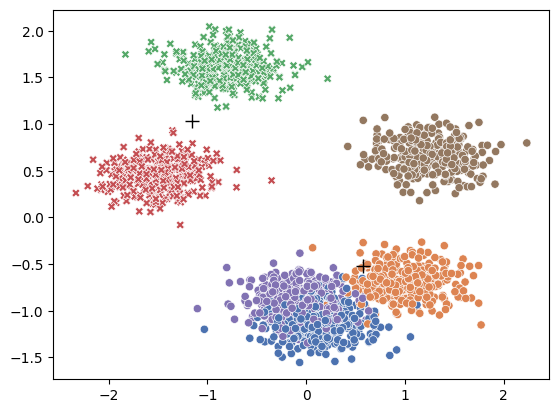

[0.6176673286348198, 4103.108459882344, 0.5042183503653689]


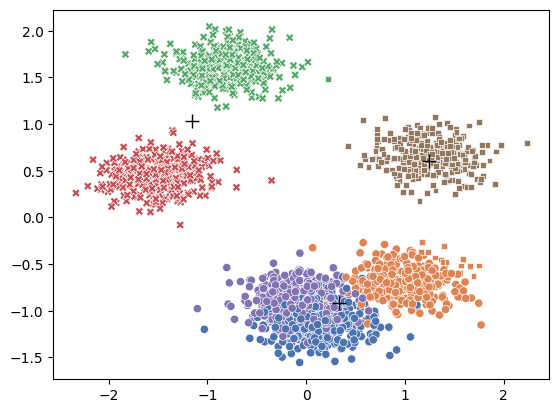

[0.5981088329608498, 4258.18614599748, 0.5155434277909385]


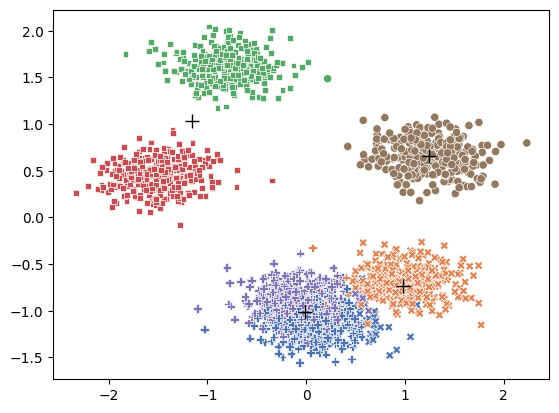

[0.642130129043415, 8249.359440361557, 0.4868344559111259]


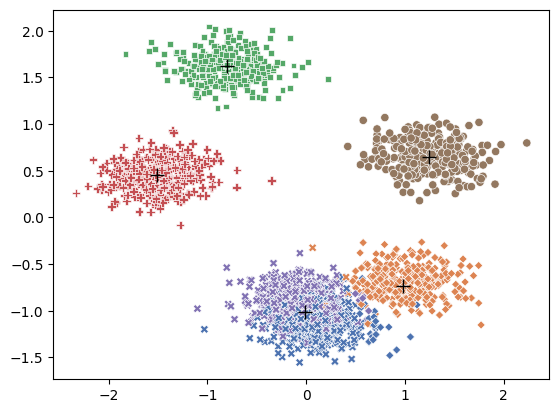

[0.5845688638151025, 7139.90261984749, 0.6471421912830164]


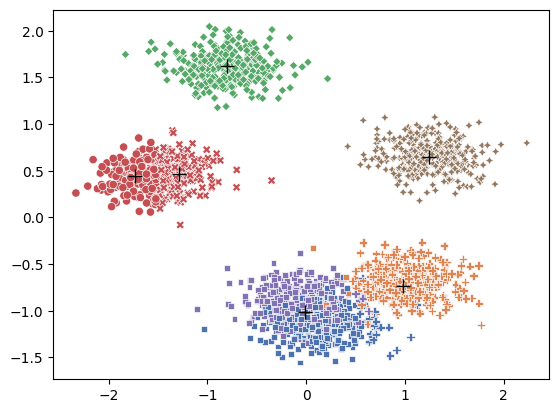

In [ ]:
for i in range(2, centers+1):
    kmeans = KMeans(n_clusters=i)
    kmeans.initializeCentroids()
    kmeans.fit(X_train)
    _,_,score=kmeans.evaluate(X_train)
    print(score)
    viewResults(X_train)

In [ ]:
_,_,score=kmeans.evaluate(X_train)
score

[0.4217817754566438, 16792.818282953802, 0.8458325400725734]

In [ ]:
def viewResults(X_train):
    # View results
    class_centers, classification, _ = kmeans.evaluate(X_train)
    sns.scatterplot(x=[X[0] for X in X_train],
                    y=[X[1] for X in X_train],
                    hue=true_labels,
                    style=classification,
                    palette="deep",
                    legend=None
                    )
    plt.plot([x for x, _ in kmeans.centroids],
            [y for _, y in kmeans.centroids],
            'k+',
            markersize=10,
            )
    plt.show()

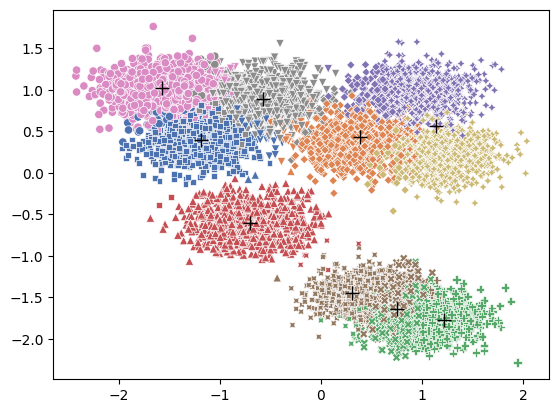

In [ ]:
viewResults(X_train)

Differential Evolution Based Optimal Clustering

In [ ]:
import math

In [ ]:
2*math.atan(0.1)/math.pi

0.06345103486110715

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from tqdm import tqdm

In [ ]:
class DEBOC:
    def __init__(self, k, X, populationSize=20, crossoverRate=0.5):
        self.k=k
        #self.kmeans=KMeans(n_clusters=self.k)
        self.X=X
        self.population=[]
        self.populationSize=populationSize
        self.crossoverRate=crossoverRate
        #self.bestSolution=[]
    def initializeCentroids(self):  #This is One Solution
        centroids = [random.choice(X_train)]
        for _ in range(self.k-1):
            dists = np.sum([euclidean(centroid, X_train) for centroid in centroids], axis=0)
            dists /= np.sum(dists)
            new_centroid_idx, = np.random.choice(range(len(X_train)), size=1, p=dists)
            centroids += [X_train[new_centroid_idx]]
        return centroids

    def initializePopulation(self):
        for _ in range(self.populationSize):
            self.population.append(self.initializeCentroids())


    def mutation_crossover(self, target):
        possible=[i for i in range(len(self.population))]
        i=random.choice(possible)
        possible.remove(i)
        j=random.choice(possible)
        possible.remove(j)
        k=random.choice(possible)
        possible.remove(k)

        F=random.random()
        mutated=[]
        #mutated=self.population[i] + F*(self.population[j]-self.population[k])
        for t in range(self.k):
            mutated.append(self.population[i][t] + F*(self.population[j][t]-self.population[k][t]))
        #Reocmbining
        trial=[]
        for t in range(self.k):
            if(random.random()<self.crossoverRate):
                trial.append(mutated[t])
            else:
                trial.append(target[t])

        self.population.append(trial)

    def runSingle(self, verbose=False):
        self.bestSolutions={}
        for i in range(self.populationSize):
            self.mutation_crossover(self.population[i])

        #Selection
        Solution2Score={}
        for i in tqdm(range(len(self.population))):
            kmeans=KMeans(n_clusters=self.k)
            kmeans.inputCentroids(self.population[i])
            kmeans.fit(self.X)
            _,_,score=kmeans.evaluate(self.X)
            Solution2Score[i]=score
        #print(len(Solution2Score))
        #Normal Silhouette Scoring
        #fittestIndexes=sorted(Solution2Score.keys(), key=lambda x: Solution2Score[x][0], reverse=True)[:self.populationSize]
        #Weighted Scoring of Silhouette Score and Davies Bouldin Score
        #fittestIndexes=sorted(Solution2Score.keys(), key=lambda x: 10*Solution2Score[x][0]+(1/Solution2Score[x][2]), reverse=True)[:self.populationSize]
        #Weighting All 3 Scores
        #Siloutte lies b/w -1 to 1, David-Bouldin lies between 0 to 1 (lower better), CH index is generally depedant on number of data points


        #APPROACH: First we transform each score to [0,1]
        #While Sorting we divide each score by the max encountered in the array, so each score gets same weightage
        #If one sample has best score in all three, it will get the score 1+1+1=3

        #fittestIndexes=sorted(Solution2Score.keys(), key=lambda x: 10*Solution2Score[x][0]+(2*Solution2Score[x][1]/self.X.shape[0])+(1/Solution2Score[x][2]), reverse=True)[:self.populationSize]
        maxSH=0  #Silhoutte Score
        maxCH=0  #Calinski-Harbasz
        maxDB=0  #David-Bouldin

        #NOTE:  DB : [0, 1] and the lower the better
        #So we have to transform DB so that higher DB means better
        # Now 1/DB : [1, inf]
        # and (1/DB)-1 : [0, inf]
        # Transforming this to unit interval, use tan-1
        # tan-1((1/DB)-1) : [0, pi/2]
        # 2/pi tan-1((1/DB)-1) : [0, 1]
        for i in Solution2Score.keys():
            maxSH=max(maxSH, (Solution2Score[i][0]+1)/2)  #Transforming Silhoutte Score from [-1,1] to [0,1]
            maxCH=max(maxCH, Solution2Score[i][1])
            maxDB=max(maxDB, 2*math.atan((1/Solution2Score[i][2]) -1)/math.pi)
        fittestIndexes=sorted(Solution2Score.keys(), key=lambda x: (((Solution2Score[x][0]+1)/2)/maxSH)+(Solution2Score[x][1]/maxCH)+((2*math.atan((1/Solution2Score[i][2]) -1)/math.pi)/maxDB), reverse=True)[:self.populationSize]

        temp=[]
        for  i in fittestIndexes:
            if verbose:
                print(i, ": ", Solution2Score[i])
                print("SCORE : ", (((Solution2Score[i][0]+1)/2)/maxSH)+(Solution2Score[i][1]/maxCH)+((2*math.atan((1/Solution2Score[i][2]) -1)/math.pi)/maxDB))
            temp.append(self.population[i])

        self.population=temp
        self.bestSolution=self.population[0]
        #SELECT ON BASIS OF SCORE
        #We'll get one generation
        #Repeat Run for some number of generations

    def runGen(self, generations=10, verbose=False):
        for i in range(generations):
            self.runSingle(verbose=verbose)

    def Solution(self):
        for i in self.population:
            kmeans=KMeans(n_clusters=self.k)
            kmeans.inputCentroids(i)
            kmeans.fit(self.X)
            class_centers, classification, score= kmeans.evaluate(self.X)
            print(len(set(classification)))
            print(score)
            #print(10*score[0]+(3*score[1]/self.X.shape[0])+(1/score[2]))
            #Plot for 2D Data
            sns.scatterplot(x=[X[0] for X in self.X],
                    y=[X[1] for X in self.X],
                    hue=true_labels,
                    style=classification,
                    palette="deep",
                    legend=None
                    )
            plt.plot([x for x, _ in kmeans.centroids],
                    [y for _, y in kmeans.centroids],
                    'k+',
                    markersize=10,
                    )
            plt.show()

In [ ]:
test=DEBOC(k=10, X=X_train, )
test.initializePopulation()
#test.population

In [ ]:
test.runGen(10, verbose=True)

100%|██████████| 40/40 [00:19<00:00,  2.08it/s]


26 :  [0.4917339461909206, 2389.111731729075, 0.8097606656720365]
SCORE :  2.997901489735998
39 :  [0.41508162848994656, 2161.304083415281, 0.984013177804134]
SCORE :  1.9216740948174003
35 :  [0.47333849028878217, 2064.910590207154, 0.8272413489101447]
SCORE :  2.742115862700641
37 :  [0.494870948219117, 2014.4712161235348, 0.8127934683558437]
SCORE :  2.824244012936832
28 :  [0.47106715575771213, 2037.3124625451278, 0.8402925357038413]
SCORE :  2.6507925488463124
30 :  [0.421503625852107, 2116.457574228723, 0.9404395983823041]
SCORE :  2.110896711502382
23 :  [0.44992573067822306, 2060.0569094534776, 0.8529007347214878]
SCORE :  2.5723564390895257
38 :  [0.44707983215673436, 2044.607607557548, 0.8990050498176814]
SCORE :  2.308653997248579
36 :  [0.40613482949995866, 2081.6494225474507, 1.0238501658727452]
SCORE :  1.7110123425185486
18 :  [0.408572406965839, 2068.884241297628, 0.9472304687928969]
SCORE :  2.04941355751789
31 :  [0.39165176446217165, 2075.0399066108616, 1.00584070588

100%|██████████| 40/40 [00:23<00:00,  1.73it/s]


39 :  [0.523701393806351, 2375.1378149324573, 0.7320678708187286]
SCORE :  2.9941509990466186
0 :  [0.4917339461909206, 2389.111731729075, 0.8097606656720365]
SCORE :  2.6367009131592645
23 :  [0.4548635943314271, 2264.514796431137, 0.8910568881840264]
SCORE :  2.249423718629682
38 :  [0.4354921625294785, 2191.1555769784945, 0.9400006331032162]
SCORE :  2.0409307432364376
20 :  [0.42859438835044417, 2189.4513250247337, 0.9509283098130585]
SCORE :  2.000962466317308
30 :  [0.4866042791298548, 2094.765873261543, 0.8051544248103867]
SCORE :  2.52918441554174
29 :  [0.4823450773080857, 2095.74943831953, 0.8486319554578534]
SCORE :  2.353159660209814
22 :  [0.44508267151296843, 2126.063891969211, 0.8536390524308125]
SCORE :  2.32227780110897
24 :  [0.43527602928005205, 2138.909407051737, 0.8907303296150754]
SCORE :  2.1851497403124065
36 :  [0.4151650733032118, 2164.5284763235654, 0.968938090978881]
SCORE :  1.926105004765899
1 :  [0.41508162848994656, 2161.304083415281, 0.984013177804134]


100%|██████████| 40/40 [00:19<00:00,  2.05it/s]


24 :  [0.5582829483057311, 2681.954200325303, 0.6134843610593362]
SCORE :  2.82817527916027
23 :  [0.5851664138351617, 2428.4206258051845, 0.5603739452857233]
SCORE :  2.9054668515631747
38 :  [0.5848144021008524, 2428.370132748541, 0.5611600976596017]
SCORE :  2.902896818200775
26 :  [0.5177679705569874, 2451.362774316663, 0.7322739261340132]
SCORE :  2.3984052521600505
0 :  [0.523701393806351, 2375.1378149324573, 0.7320678708187286]
SCORE :  2.37423653769147
32 :  [0.5036445202241686, 2388.1219361707354, 0.7965544327349027]
SCORE :  2.2149135561827498
36 :  [0.49752946551172544, 2391.6818349928117, 0.8019112883508684]
SCORE :  2.2005251209276557
1 :  [0.4917339461909206, 2389.111731729075, 0.8097606656720365]
SCORE :  2.178737150955074
25 :  [0.5049097108182853, 2238.249047159454, 0.7473412547324592]
SCORE :  2.2740041866566036
2 :  [0.4548635943314271, 2264.514796431137, 0.8910568881840264]
SCORE :  1.9450332356132767
21 :  [0.4514905995276599, 2263.2455079592496, 0.8722837639805328

100%|██████████| 40/40 [00:18<00:00,  2.20it/s]


0 :  [0.5582829483057311, 2681.954200325303, 0.6134843610593362]
SCORE :  2.8190297242625157
38 :  [0.5582829483057311, 2681.954200325303, 0.6134843610593361]
SCORE :  2.819029724262516
1 :  [0.5851664138351617, 2428.4206258051845, 0.5603739452857233]
SCORE :  2.894645434382554
22 :  [0.5849867506136938, 2428.422905764334, 0.5607612723511803]
SCORE :  2.893397716571886
2 :  [0.5848144021008524, 2428.370132748541, 0.5611600976596017]
SCORE :  2.8921006056189147
27 :  [0.5177679705569874, 2451.362774316664, 0.7322739261340132]
SCORE :  2.3927034220383754
3 :  [0.5177679705569874, 2451.362774316663, 0.7322739261340132]
SCORE :  2.392703422038375
23 :  [0.5177670171885153, 2451.3268797346796, 0.7337657835033357]
SCORE :  2.389044421801896
28 :  [0.5109886182618546, 2428.2121306581066, 0.7409559693379181]
SCORE :  2.3586992283697503
4 :  [0.523701393806351, 2375.1378149324573, 0.7320678708187286]
SCORE :  2.3685291927749565
5 :  [0.5036445202241686, 2388.1219361707354, 0.7965544327349027]
S

100%|██████████| 40/40 [00:14<00:00,  2.76it/s]


20 :  [0.5584058841412748, 2681.7815109868184, 0.6124637572187625]
SCORE :  2.831107816079151
22 :  [0.5584058841412748, 2681.7815109868184, 0.6124637572187625]
SCORE :  2.831107816079151
30 :  [0.5584058841412748, 2681.7815109868184, 0.6124637572187625]
SCORE :  2.831107816079151
33 :  [0.5584058841412748, 2681.781510986819, 0.6124637572187625]
SCORE :  2.8311078160791516
34 :  [0.5584058841412748, 2681.7815109868184, 0.6124637572187625]
SCORE :  2.831107816079151
0 :  [0.5582829483057311, 2681.954200325303, 0.6134843610593362]
SCORE :  2.8281752791602695
1 :  [0.5582829483057311, 2681.954200325303, 0.6134843610593361]
SCORE :  2.82817527916027
21 :  [0.5582829483057311, 2681.954200325303, 0.6134843610593361]
SCORE :  2.82817527916027
23 :  [0.5582829483057311, 2681.954200325303, 0.6134843610593362]
SCORE :  2.8281752791602695
25 :  [0.5582829483057311, 2681.954200325303, 0.6134843610593361]
SCORE :  2.82817527916027
28 :  [0.5582829483057311, 2681.9542003253036, 0.6134843610593361]
S

100%|██████████| 40/40 [00:14<00:00,  2.84it/s]


3 :  [0.5584058841412748, 2681.781510986819, 0.6124637572187625]
SCORE :  2.8219306694348694
26 :  [0.5584058841412748, 2681.781510986819, 0.6124637572187625]
SCORE :  2.8219306694348694
37 :  [0.5584058841412748, 2681.781510986819, 0.6124637572187625]
SCORE :  2.8219306694348694
0 :  [0.5584058841412748, 2681.7815109868184, 0.6124637572187625]
SCORE :  2.8219306694348694
1 :  [0.5584058841412748, 2681.7815109868184, 0.6124637572187625]
SCORE :  2.8219306694348694
2 :  [0.5584058841412748, 2681.7815109868184, 0.6124637572187625]
SCORE :  2.8219306694348694
4 :  [0.5584058841412748, 2681.7815109868184, 0.6124637572187625]
SCORE :  2.8219306694348694
10 :  [0.5582829483057311, 2681.9542003253036, 0.6134843610593361]
SCORE :  2.8190297242625157
12 :  [0.5582829483057311, 2681.9542003253036, 0.6134843610593362]
SCORE :  2.8190297242625153
5 :  [0.5582829483057311, 2681.954200325303, 0.6134843610593362]
SCORE :  2.8190297242625153
6 :  [0.5582829483057311, 2681.954200325303, 0.6134843610593

100%|██████████| 40/40 [00:12<00:00,  3.13it/s]


0 :  [0.5584058841412748, 2681.781510986819, 0.6124637572187625]
SCORE :  2.8311078160791516
1 :  [0.5584058841412748, 2681.781510986819, 0.6124637572187625]
SCORE :  2.8311078160791516
2 :  [0.5584058841412748, 2681.781510986819, 0.6124637572187625]
SCORE :  2.8311078160791516
36 :  [0.5584058841412748, 2681.781510986819, 0.6124637572187625]
SCORE :  2.8311078160791516
3 :  [0.5584058841412748, 2681.7815109868184, 0.6124637572187625]
SCORE :  2.831107816079151
4 :  [0.5584058841412748, 2681.7815109868184, 0.6124637572187625]
SCORE :  2.831107816079151
5 :  [0.5584058841412748, 2681.7815109868184, 0.6124637572187625]
SCORE :  2.831107816079151
6 :  [0.5584058841412748, 2681.7815109868184, 0.6124637572187625]
SCORE :  2.831107816079151
7 :  [0.5582829483057311, 2681.9542003253036, 0.6134843610593361]
SCORE :  2.8281752791602703
8 :  [0.5582829483057311, 2681.9542003253036, 0.6134843610593362]
SCORE :  2.82817527916027
9 :  [0.5582829483057311, 2681.954200325303, 0.6134843610593362]
SCOR

100%|██████████| 40/40 [00:14<00:00,  2.83it/s]


0 :  [0.5584058841412748, 2681.781510986819, 0.6124637572187625]
SCORE :  2.8221490351483585
1 :  [0.5584058841412748, 2681.781510986819, 0.6124637572187625]
SCORE :  2.8221490351483585
2 :  [0.5584058841412748, 2681.781510986819, 0.6124637572187625]
SCORE :  2.8221490351483585
3 :  [0.5584058841412748, 2681.781510986819, 0.6124637572187625]
SCORE :  2.8221490351483585
22 :  [0.5584058841412748, 2681.781510986819, 0.6124637572187625]
SCORE :  2.8221490351483585
34 :  [0.5584058841412748, 2681.781510986819, 0.6124637572187625]
SCORE :  2.8221490351483585
4 :  [0.5584058841412748, 2681.7815109868184, 0.6124637572187625]
SCORE :  2.822149035148358
5 :  [0.5584058841412748, 2681.7815109868184, 0.6124637572187625]
SCORE :  2.822149035148358
6 :  [0.5584058841412748, 2681.7815109868184, 0.6124637572187625]
SCORE :  2.822149035148358
7 :  [0.5584058841412748, 2681.7815109868184, 0.6124637572187625]
SCORE :  2.822149035148358
8 :  [0.5582829483057311, 2681.9542003253036, 0.6134843610593361]
SC

100%|██████████| 40/40 [00:13<00:00,  2.93it/s]


0 :  [0.5584058841412748, 2681.781510986819, 0.6124637572187625]
SCORE :  2.82193066943487
1 :  [0.5584058841412748, 2681.781510986819, 0.6124637572187625]
SCORE :  2.82193066943487
2 :  [0.5584058841412748, 2681.781510986819, 0.6124637572187625]
SCORE :  2.82193066943487
3 :  [0.5584058841412748, 2681.781510986819, 0.6124637572187625]
SCORE :  2.82193066943487
4 :  [0.5584058841412748, 2681.781510986819, 0.6124637572187625]
SCORE :  2.82193066943487
5 :  [0.5584058841412748, 2681.781510986819, 0.6124637572187625]
SCORE :  2.82193066943487
36 :  [0.5584058841412748, 2681.781510986819, 0.6124637572187625]
SCORE :  2.82193066943487
6 :  [0.5584058841412748, 2681.7815109868184, 0.6124637572187625]
SCORE :  2.8219306694348694
7 :  [0.5584058841412748, 2681.7815109868184, 0.6124637572187625]
SCORE :  2.8219306694348694
8 :  [0.5584058841412748, 2681.7815109868184, 0.6124637572187625]
SCORE :  2.8219306694348694
9 :  [0.5584058841412748, 2681.7815109868184, 0.6124637572187625]
SCORE :  2.821

100%|██████████| 40/40 [00:14<00:00,  2.78it/s]

0 :  [0.5584058841412748, 2681.781510986819, 0.6124637572187625]
SCORE :  2.8333060299887665
1 :  [0.5584058841412748, 2681.781510986819, 0.6124637572187625]
SCORE :  2.8333060299887665
2 :  [0.5584058841412748, 2681.781510986819, 0.6124637572187625]
SCORE :  2.8333060299887665
3 :  [0.5584058841412748, 2681.781510986819, 0.6124637572187625]
SCORE :  2.8333060299887665
4 :  [0.5584058841412748, 2681.781510986819, 0.6124637572187625]
SCORE :  2.8333060299887665
5 :  [0.5584058841412748, 2681.781510986819, 0.6124637572187625]
SCORE :  2.8333060299887665
6 :  [0.5584058841412748, 2681.781510986819, 0.6124637572187625]
SCORE :  2.8333060299887665
33 :  [0.5584058841412748, 2681.781510986819, 0.6124637572187625]
SCORE :  2.8333060299887665
7 :  [0.5584058841412748, 2681.7815109868184, 0.6124637572187625]
SCORE :  2.833306029988766
8 :  [0.5584058841412748, 2681.7815109868184, 0.6124637572187625]
SCORE :  2.833306029988766
9 :  [0.5584058841412748, 2681.7815109868184, 0.6124637572187625]
SCO

RAN MODEL WITH K=10 ON A DATASET WITH 6 CLUSTERS, OUR MODEL WAS ABLE TO FIND THE 6 CLUSTERS, AND HAS DISCARDED THE OTHER 4 CENTROIDS

6
[0.5584058841412748, 2681.781510986819, 0.6124637572187625]


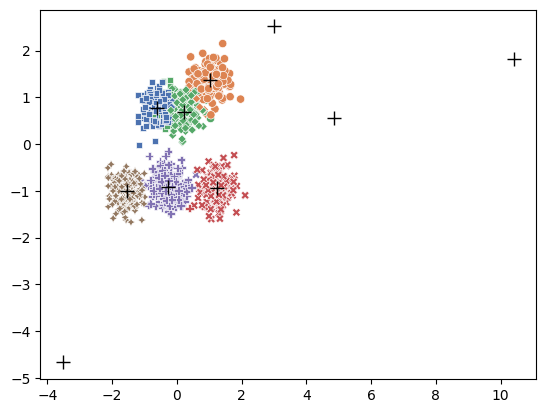

6
[0.5584058841412748, 2681.781510986819, 0.6124637572187625]


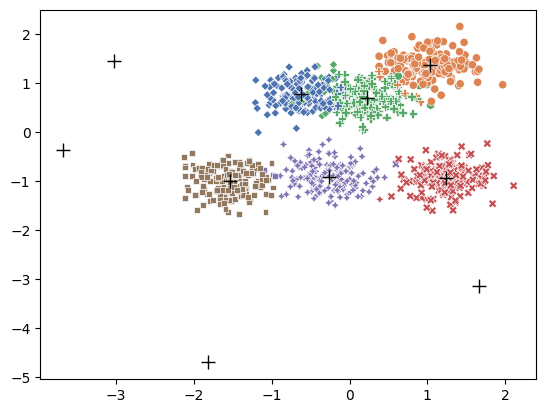

6
[0.5584058841412748, 2681.781510986819, 0.6124637572187625]


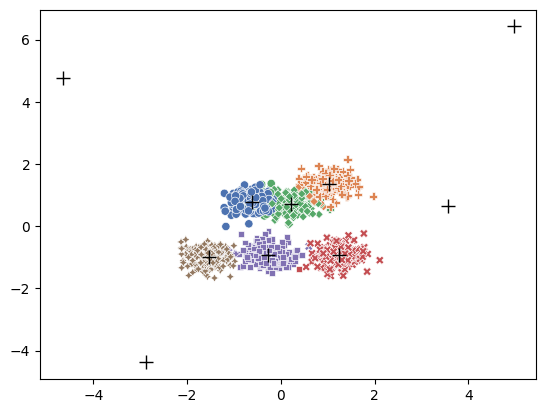

6
[0.5584058841412748, 2681.781510986819, 0.6124637572187625]


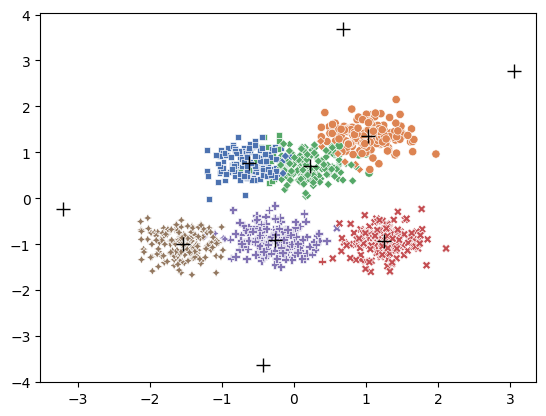

6
[0.5584058841412748, 2681.781510986819, 0.6124637572187625]


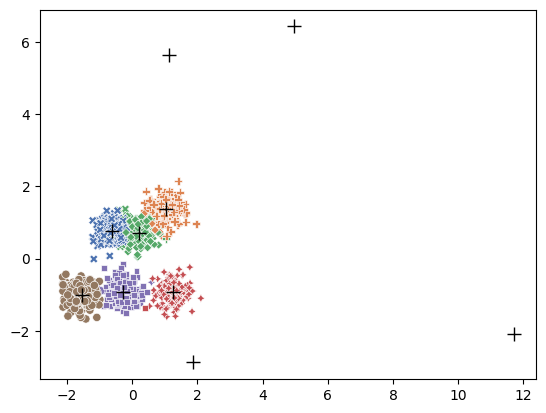

6
[0.5584058841412748, 2681.781510986819, 0.6124637572187625]


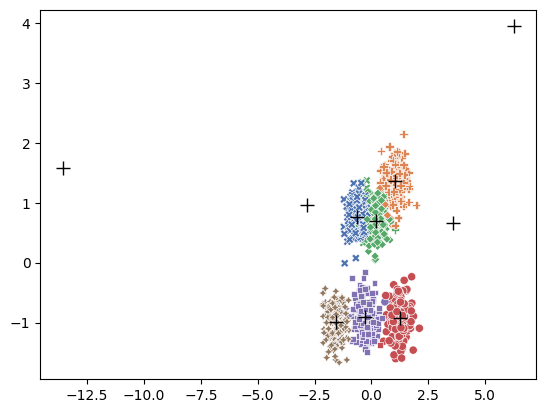

6
[0.5584058841412748, 2681.781510986819, 0.6124637572187625]


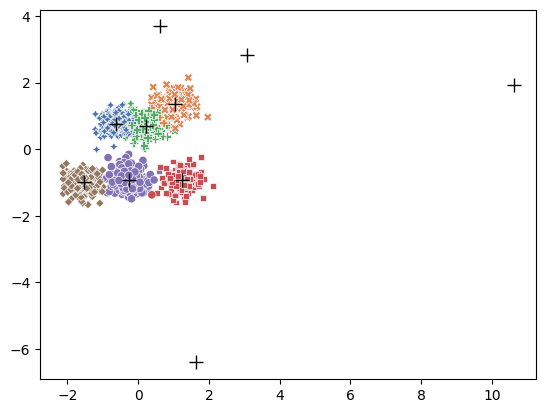

6
[0.5584058841412748, 2681.781510986819, 0.6124637572187625]


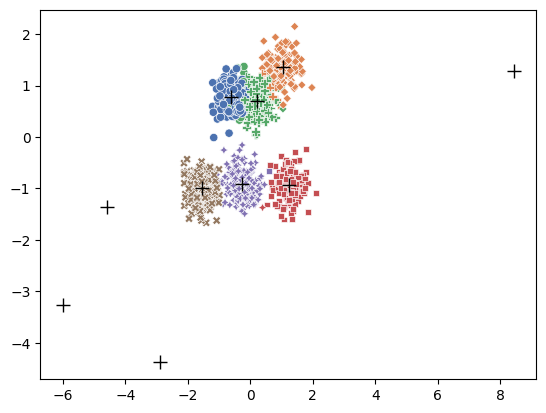

6
[0.5584058841412748, 2681.7815109868184, 0.6124637572187625]


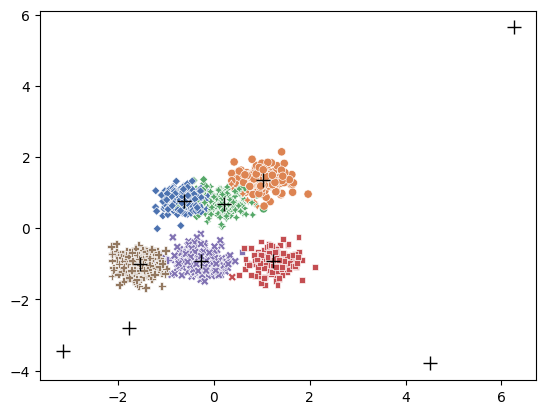

6
[0.5584058841412748, 2681.7815109868184, 0.6124637572187625]


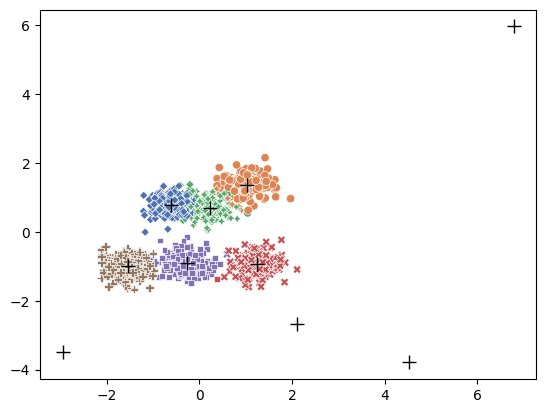

6
[0.5584058841412748, 2681.7815109868184, 0.6124637572187625]


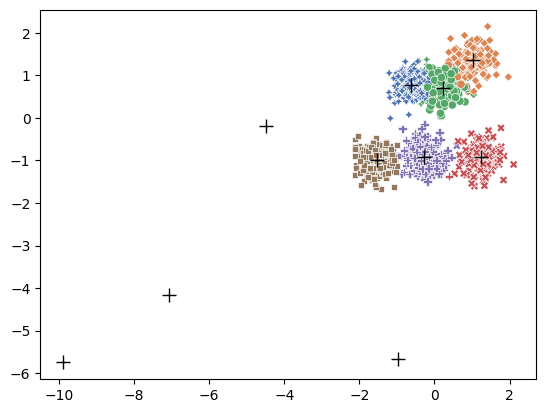

6
[0.5584058841412748, 2681.7815109868184, 0.6124637572187625]


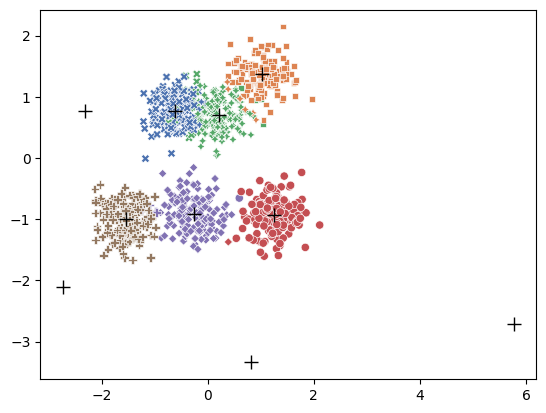

6
[0.5582829483057311, 2681.9542003253036, 0.6134843610593361]


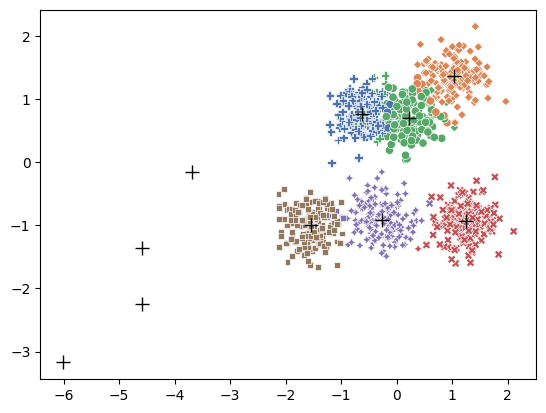

6
[0.5582829483057311, 2681.9542003253036, 0.6134843610593362]


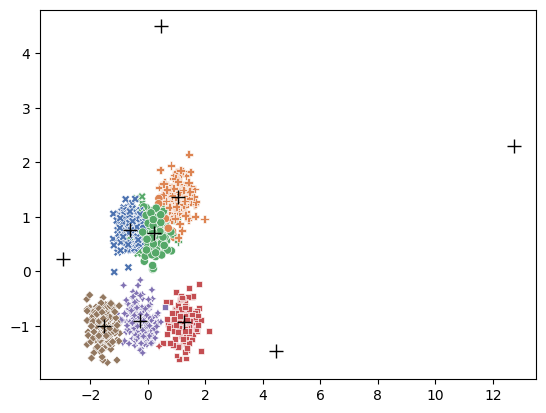

6
[0.5582829483057311, 2681.9542003253036, 0.6134843610593361]


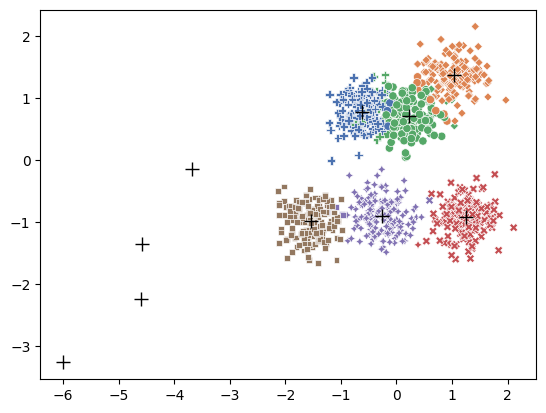

6
[0.5582829483057311, 2681.9542003253036, 0.6134843610593361]


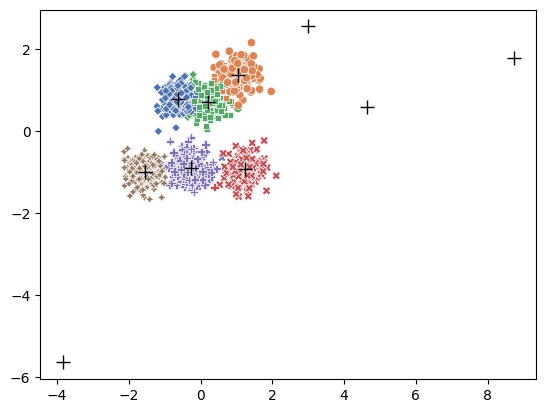

6
[0.5582829483057311, 2681.9542003253036, 0.6134843610593362]


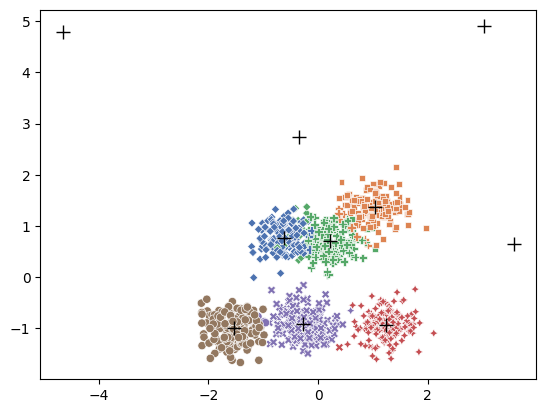

6
[0.5582829483057311, 2681.954200325303, 0.6134843610593362]


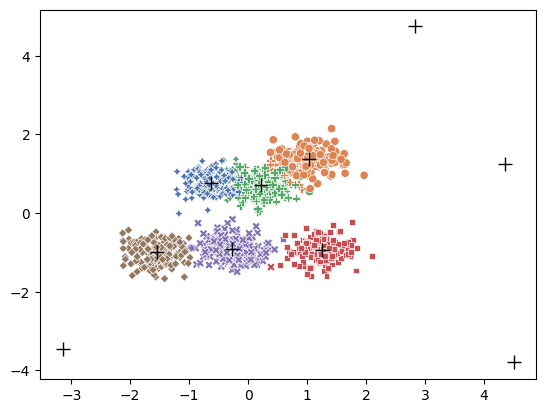

6
[0.5582829483057311, 2681.954200325303, 0.6134843610593361]


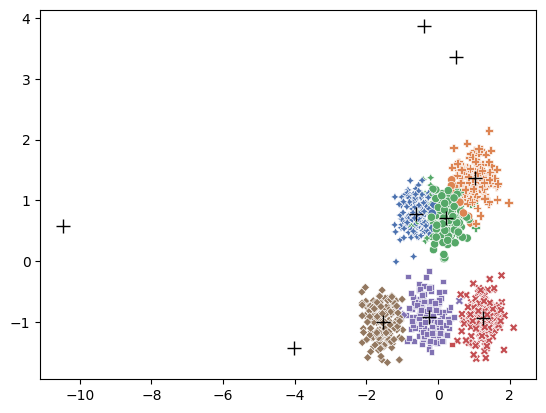

6
[0.5582829483057311, 2681.954200325303, 0.6134843610593361]


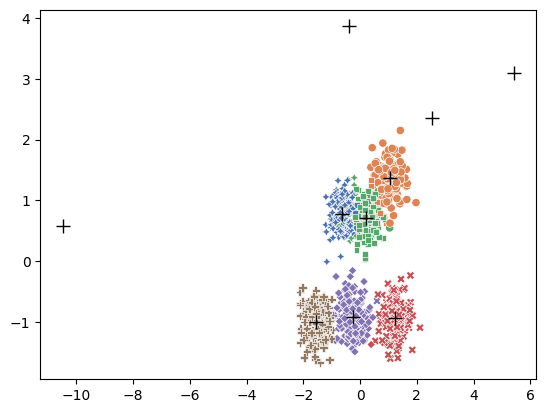

In [ ]:
test.Solution()

Next Step: Remove Empty Centroids

KMEANS IMPLEMENTATION


In [ ]:
import numpy as np
import math
import pandas as pd
import random

In [ ]:
t1=np.array([4,3,1,32,2,1])

In [ ]:
t1.var()

124.47222222222221

In [ ]:
t2=np.array([0,0])

In [ ]:
math.sqrt(np.sum(t2*t2-t1*t1))

ValueError: ignored

In [ ]:
path='/content/drive/MyDrive/WINE CLUSTER/wine-clustering.csv'

In [ ]:
data=pd.read_csv(path)

In [ ]:
data.shape

(178, 13)

In [ ]:
data.columns

Index(['Alcohol', 'Malic_Acid', 'Ash', 'Ash_Alcanity', 'Magnesium',
       'Total_Phenols', 'Flavanoids', 'Nonflavanoid_Phenols',
       'Proanthocyanins', 'Color_Intensity', 'Hue', 'OD280', 'Proline'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.to_numpy())
data_scaled = pd.DataFrame(data_scaled, columns=['Alcohol', 'Malic_Acid', 'Ash', 'Ash_Alcanity', 'Magnesium',
       'Total_Phenols', 'Flavanoids', 'Nonflavanoid_Phenols',
       'Proanthocyanins', 'Color_Intensity', 'Hue', 'OD280', 'Proline'])

print("Scaled Dataset Using MinMaxScaler")
data_scaled.head()

Scaled Dataset Using MinMaxScaler


,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341
1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642
2,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933
3,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347
4,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963


In [ ]:
data

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [ ]:
class KMeans:
    def __init__(self, data, k=8, centroids=-1, iter=500,):
        self.centroids=-1
        self.k=k
        self.data=data
        self.iter=iter
        self.dimension=data.shape[1]
        self.instanceToCluster=[-1 for i in range(data.shape[0])]
        self.prevError=np.Inf

    def randomCentroids(self):
        Centroids=[]
        for i in range(self.k):
            temp=[]
            for i in range(self.dimension):
                temp.append(random.choice(self.data.iloc[:, i].values))
            Centroids.append(temp)
        return Centroids

    def fit(self):
        if self.centroids==-1:
            Centroids=self.randomCentroids()
        print(Centroids)




        for _ in range(self.iter):
            '''
            #Distance Evaluation
            error=0
            for i in range(len(self.instanceToCluster)):
                point=np.array(data.iloc[i,:].values)

                #print(point)
                centroid=np.array(Centroids[self.instanceToCluster[i]])
                #error+=math.sqrt(abs(np.sum(point*point-centroid*centroid)))
                #error=error
                error+=math.sqrt(abs(np.sum((point-centroid)*(point-centroid))))
                error=error
            if((self.prevError-error)<=0.01):
                break
            self.prevError=error
            print(error)
            '''

            #Assign data points to nearest centroid
            for i in range(len(self.instanceToCluster)):
                distToCentroids=[]
                point=data.iloc[i,:].values
                #print(point)
                for centroid in Centroids:
                    centroid=np.array(centroid)
                    point=np.array(point)
                    distToCentroids.append(math.sqrt(abs(np.sum(point*point-centroid*centroid))))
                closest=np.argmin(distToCentroids)
                self.instanceToCluster[i]=closest

            #print(self.instanceToCluster)

            #Update Centroid by Centroid of the Cluster
            for i in range(len(Centroids)):
                newCentroid=np.zeros(self.dimension)
                count=1
                for j in range(len(self.instanceToCluster)):
                    if i==self.instanceToCluster[j]:
                        newCentroid+=np.array(data.iloc[j,:].values)
                        count+=1
                Centroids[i]=np.divide(newCentroid, count)

            #Variation Evaluation
            clusterToInstances={i:[] for i in range(self.k)}
            for i in range(len(self.instanceToCluster)):
                clusterToInstances[self.instanceToCluster[i]].append(data.iloc[i, :].values)
            #print(clusterToInstance)
            error=0
            for i in range(self.k):
                #print(clusterToInstances[i])
                val=np.array(clusterToInstances[i]).var()/len(clusterToInstances[i])
                if np.isnan(val):
                    val=0
                error+=val
                print("Cluster: ", i, " Within-Variance: ", val)
            print("ERROR: ", error)

            '''
            if((self.prevError-error)<=0.01):
                break
            self.prevError=error
            print(error)
            '''
            #temp=pd.DataFrame(clusterToInstance)
            #print(temp)

        for centroid in Centroids:
            print(centroid)





In [ ]:
kmeans=KMeans(data_scaled, k=5, iter=200)

In [ ]:
kmeans.fit()

[[0.2763157894736845, 0.14031620553359683, 0.7005347593582886, 0.5618556701030928, 0.6304347826086957, 0.14482758620689656, 0.6962025316455696, 0.16981132075471697, 0.3817034700315458, 0.26450511945392485, 0.3463414634146342, 0.7435897435897436, 0.5399429386590585], [0.7052631578947373, 0.6047430830039526, 0.6310160427807486, 0.4072164948453608, 0.2934782608695653, 0.7310344827586208, 0.10337552742616031, 0.5660377358490566, 0.0031545741324921217, 0.5307167235494881, 0.3089430894308944, 0.6336996336996337, 0.40442225392296727], [0.4868421052631584, 0.36561264822134387, 0.5989304812834223, 0.38144329896907214, 0.6195652173913043, 0.21379310344827596, 0.18565400843881852, 0.11320754716981132, 0.26498422712933756, 0.057167235494880536, 0.39024390243902435, 0.11355311355311354, 0.15834522111269614], [0.7105263157894739, 0.8498023715415021, 0.7914438502673796, 0.48453608247422686, 0.3695652173913043, 0.606896551724138, 0.23628691983122357, 0.1320754716981132, 0.3627760252365931, 0.893344709

<ipython-input-19-815318f81788>:79: RuntimeWarning: Degrees of freedom <= 0 for slice
  val=np.array(clusterToInstances[i]).var()/len(clusterToInstances[i])


Cluster:  0  Within-Variance:  0
Cluster:  1  Within-Variance:  0
Cluster:  2  Within-Variance:  0
Cluster:  3  Within-Variance:  261.49676757753866
Cluster:  4  Within-Variance:  0
ERROR:  261.49676757753866
Cluster:  0  Within-Variance:  242.29835296285714
Cluster:  1  Within-Variance:  0
Cluster:  2  Within-Variance:  0
Cluster:  3  Within-Variance:  502.22998992472304
Cluster:  4  Within-Variance:  0
ERROR:  744.5283428875802
Cluster:  0  Within-Variance:  205.2282562444858
Cluster:  1  Within-Variance:  2895.4195166420122
Cluster:  2  Within-Variance:  0
Cluster:  3  Within-Variance:  985.5592905995487
Cluster:  4  Within-Variance:  0
ERROR:  4086.2070634860465
Cluster:  0  Within-Variance:  246.01354744892217
Cluster:  1  Within-Variance:  532.1064383261777
Cluster:  2  Within-Variance:  0
Cluster:  3  Within-Variance:  1457.7701833427136
Cluster:  4  Within-Variance:  0
ERROR:  2235.8901691178135
Cluster:  0  Within-Variance:  318.4787354363463
Cluster:  1  Within-Variance:  327